# LLM Bot Demo with MLRun

In [1]:
import mlrun

### Setup Project

In [2]:
project = mlrun.get_or_create_project(
    name="llmbot",
    parameters={
        "source" : "v3io:///bigdata/demo-llm-bot.zip",
        # "source" : "git://github.com/mlrun/demo-llm-bot#main",
        "secrets_file" : "secrets.env",
        "image" : "nschenone/llmbot:1.4.1"
    }
)

> 2024-01-04 23:15:30,122 [info] Created and saved project: {'name': 'llmbot', 'from_template': None, 'overwrite': False, 'context': './', 'save': True}
Project Source: v3io:///bigdata/demo-llm-bot.zip
Exporting project as zip archive to v3io:///bigdata/demo-llm-bot.zip...
> 2024-01-04 23:15:30,873 [info] Project created successfully: {'project_name': 'llmbot', 'stored_in_db': True}


### Ingest Data and Deploy LLM

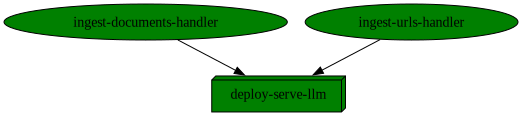

uid,start,state,name,parameters,results
...6bfdfb05,Jan 04 23:15:53,completed,ingest-urls-handler,urls_file=data/urls/mlops_blogs.txt,
...b839088d,Jan 04 23:15:53,completed,ingest-documents-handler,source_directory=data/mlrun_docs_md,


7da0c1da-b6b9-4625-a054-dc7314898ac4

In [3]:
project.run(
    name="main",
    arguments={
        "source_directory" : "data/mlrun_docs_md",
        "urls_file" : "data/urls/mlops_blogs.txt"
    },
    watch=True,
    dirty=True
)

### Query LLM via API

In [4]:
import os
import requests

# Get model serving endpoint port
serving_fn = project.get_function("serve-llm", sync=True)

MODEL_ENDPOINT_URL = serving_fn.get_url()
print(f"Model endpoint: {MODEL_ENDPOINT_URL}")

Model endpoint: http://nuclio-llmbot-serve-llm.default-tenant.svc.cluster.local:8080


In [5]:
resp = requests.post(url=MODEL_ENDPOINT_URL, json={"question" : "how I deploy an sklearn model with mlrun?", "chat_history" : []})
resp.json()

{'question': 'how I deploy an sklearn model with mlrun?',
 'chat_history': [],
 'output': 'To deploy an sklearn model with mlrun, you can use the `mlrun.deploy_function` function. Here is an example code snippet:\n\n```\nserving_fn = mlrun.new_function("serving", image="mlrun/mlrun", kind="serving")\nmlrun.deploy_function(\n  serving_fn,\n  models=[\n      {\n          "key": model_name,\n          "model_path": train.outputs["model"],\n          "class_name": \'mlrun.frameworks.sklearn.SklearnModelServer\',\n      }\n  ],\n)\n```\n\nYou can also use the `apply_mlrun` function from the `mlrun.frameworks.sklearn` module to apply mlrun to your sklearn model. Here is an example code snippet:\n\n```\nfrom mlrun.frameworks.sklearn import apply_mlrun\n\napply_mlrun(model=model, model_name="my_model", x_test=X_test, y_test=y_test)\nmodel.fit(X_train, y_train)\n```\n\nFor more information and examples, you can refer to the mlrun documentation sources provided below.\n\nSOURCES:\n- data/mlrun_d

In [6]:
resp = requests.post(url=MODEL_ENDPOINT_URL, json={"question" : "What is the average weight of Adelie penguins?", "chat_history" : []})
resp.json()

{'question': 'What is the average weight of Adelie penguins?',
 'chat_history': [],
 'output': '3706.16 grams'}

### Query LLM via Chat Interface

In [7]:
import re

import gradio as gr
import requests
from langchain.memory import ConversationBufferMemory
from langchain.schema import messages_to_dict

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


def enrich_docs_url(ai_message: str) -> str:
    pattern = r"data/mlrun_docs_md/(.*?)\.md"
    new_url = r"https://docs.mlrun.org/en/latest/\1.html"
    return re.sub(pattern, new_url, ai_message)


def query_llm(message: str) -> str:
    resp = requests.post(
        url=MODEL_ENDPOINT_URL,
        json={
            "question": message,
            "chat_history": messages_to_dict(memory.chat_memory.messages),
        },
        verify=False,
    )
    resp_json = resp.json()
    ai_message = resp_json["output"]
    memory.save_context({"input": message}, {"output": ai_message})
    ai_message = enrich_docs_url(ai_message=ai_message)
    return ai_message


def reset_memory() -> None:
    memory.clear()
    return None


with gr.Blocks(analytics_enabled=False, theme=gr.themes.Soft()) as chat:
    with gr.Row():
        chatbot = gr.Chatbot()
    with gr.Row():
        with gr.Column(scale=6):
            message = gr.Textbox(label="Q:", placeholder="Type a question and Enter")
        with gr.Column(scale=3):
            clear = gr.Button("Clear")

    def respond(message, chat_history):
        bot_message = query_llm(message=message)
        chat_history.append((message, bot_message))
        return "", chat_history

    message.submit(respond, [message, chatbot], [message, chatbot])
    clear.click(reset_memory, None, chatbot, queue=False)

chat.launch(server_name="0.0.0.0", share=True, ssl_verify=False)

Running on local URL:  http://0.0.0.0:7860
Running on public URL: https://65c537de6121616438.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [13]:
chat.close()

Closing server running on port: 7860
